# Final Project: Valiant Analysts

Welcome to the Valiant Analysts' final project: Valiant Analysis! Feel free to run this notebook top to bottom to see all of our work (although be warned - several models will be trained and this could take up to hours)! Feel free to run sections instead to save on computing power. We have included our trained models in the .zip file to make it easier to call our models, additionally, running the pre-trained models should work. Please be careful running this notebook on CUDA cores as it may act erratically (we believe it attempts to load all the models into the GPU VRAM at once which requires something like 6-8 GB).

## Dashboard Instructions

In order to run the dashboard, which is separate from this notebook, run the command ```python app.py``` or ```python3 app.py```. This will run a Flask server with the demo dashboard with our pipeline. In the terminal, you will see the URL for the server. Please navigate to this URL in your browser to utilize the dashboard. Save all audio files as they are supposed to be named within the root directory of the project to use them and then simply press analyze!

Dependencies all rely on the newest version of all imports and Python as of 4/17/23 as a dependency file was not created.

In [1]:
# imports
import sys, os
import whisper
import warnings
import sounddevice as sd
import soundfile as sf
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset
import matplotlib.pyplot as plt
import librosa
import torch
import requests
from transformers import squad_convert_examples_to_features
from transformers.data.processors.squad import SquadResult, SquadV2Processor
from transformers.data.metrics.squad_metrics import compute_predictions_logits, squad_evaluate
from scipy import optimize
from transformers import BertForQuestionAnswering, BertTokenizer
import pandas as pd
import seaborn as sns
import spacy
from spacy.tokens import Doc
from spacy import displacy
from sklearn.metrics import f1_score
from sent_analysis_naive_bayes import TextClassify, all_score
from datasets import load_dataset
from sent_analysis_finetuned import SentAnalysisFineTunedBERT
from sent_analysis_bert import SentAnalysisBERT
from transformers import pipeline

2023-04-19 00:28:17.532578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/arnav/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


## Whisper model

In [2]:
sys.path.insert(0, os.path.abspath('../../'))

# ignore warnings
warnings.filterwarnings('ignore')

In [3]:
# transcribe audio function 
def transcribe_audio(mp3: str, model) -> str:
    """
    Transcribes an audio file (in MP3 format) into text.

    Parameters:
    - mp3 (str): The path to the audio file.
    - model: The model to use for transcribing the audio.

    Returns:
    - str: The transcribed text.
    """
    print('[Transcribing audio]')
    results = model.transcribe(mp3)
    return results["text"]


In [4]:
# whisper models
model_tiny = whisper.load_model("tiny")
model_base = whisper.load_model("base")
model_small = whisper.load_model("small")
model_medium = whisper.load_model("medium")

100%|█████████████████████████████████████| 72.1M/72.1M [00:01<00:00, 43.1MiB/s]
100%|███████████████████████████████████████| 139M/139M [00:04<00:00, 31.6MiB/s]
100%|███████████████████████████████████████| 461M/461M [00:14<00:00, 33.8MiB/s]
100%|█████████████████████████████████████| 1.42G/1.42G [00:57<00:00, 26.6MiB/s]


In [6]:
# Transcribe the audio
transcribed_text_tiny = transcribe_audio('file.wav', model_tiny)
transcribed_text_base = transcribe_audio('file.wav', model_base)
transcribed_text_small = transcribe_audio('file.wav', model_small)
transcribed_text_medium = transcribe_audio('file.wav', model_medium)

[Transcribing audio]
[Transcribing audio]
[Transcribing audio]
[Transcribing audio]


In [7]:
# view the text generated by each model
# generate a dataframe with tiny, base, small, medium as the rows
df = pd.DataFrame([transcribed_text_tiny, transcribed_text_base, transcribed_text_small, transcribed_text_medium], index=['tiny', 'base', 'small', 'medium'])
df

,0
tiny,"Alright, today was a really incredible day. I..."
base,"All right, today was a really incredible day...."
small,"All right, today was a really incredible day...."
medium,"Alright, today was a really incredible day. I..."


### viewing the transcribed texts for each model individually

In [8]:
transcribed_text_tiny

" Alright, today was a really incredible day. I'm relieved as hell for being a professional really to be over. Um, showcase what really well. I feel like my speech will well. I'm not nervous anymore. Um, and I'm really happy."

In [9]:
transcribed_text_small

" All right, today was a really incredible day. I'm relieved as hell for being a projectile to be over. Showcase went really well. I feel like my speech went well. I'm not nervous anymore. And I'm really happy."

In [10]:
transcribed_text_base

" All right, today was a really incredible day. I'm relieved as hell for being approached I could lead to be over. Showcase went really well. I feel like my speech went well. I'm not nervous anymore. And I'm really happy."

In [11]:
transcribed_text_medium

" Alright, today was a really incredible day. I'm relieved as hell for being a project lead to be over. Showcase went really well. I feel like my speech went well. I'm not nervous anymore and I'm really happy."

In [12]:
# record audio 
duration = 5  # seconds
fs = 16000  # Sample rate
seconds = 5  # Duration of recording

print("Recording Audio")
myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished
print("Audio recording complete , Play Audio")
filename = 'file.wav'
sf.write(filename, myrecording, fs)  # Save as WAV file

Recording Audio
Audio recording complete , Play Audio


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


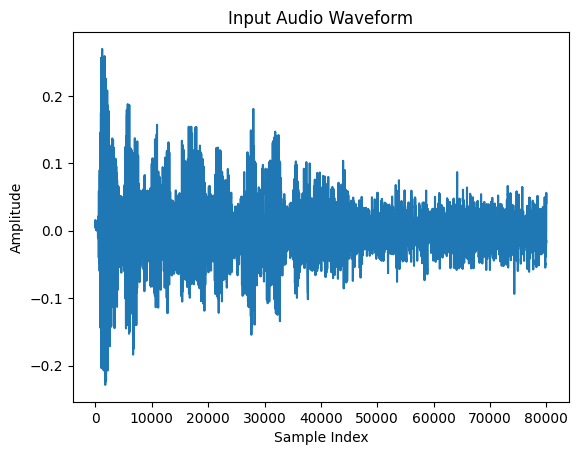

In [13]:
# use whisper to process
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-960h')
model = Wav2Vec2ForCTC.from_pretrained('facebook/wav2vec2-base-960h')

input_audio, _ = librosa.load('file.wav', sr=16000)
input_feature = processor(input_audio, sampling_rate=16000, return_tensors='pt').input_values
output_text = model(input_feature).logits.argmax(dim=-1)

# Visualize the input audio waveform
plt.plot(input_audio)
plt.title('Input Audio Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

In [14]:
# Visualize the predicted transcription
predicted_text = processor.decode(output_text[0])
actual_text = " Alright, today was a really incredible day. I'm relieved as hell for being a project lead to be over. Showcase went really well. I feel like my speech went well. I'm not nervous anymore and I'm really happy."
print('Predicted Transcription:', predicted_text)
print('Actual Transcription:', actual_text)

Predicted Transcription: LONG TIMES I DID BILE THINGS AND NOT GUT AT THEM E NE MORE
Actual Transcription:  Alright, today was a really incredible day. I'm relieved as hell for being a project lead to be over. Showcase went really well. I feel like my speech went well. I'm not nervous anymore and I'm really happy.


## BERT Model

### Steps:
1. Preprocessing the SQuAD dataset [[here](https://huggingface.co/datasets/squad)]
2. Fine-tuning a pre-trained BERT model on the preprocessed dataset
3. Evaluating the fine-tuned model on the SQuAD test set

#### Download the SQuAD data

In [15]:
# Download the train set
url = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json'
response = requests.get(url)
with open('train-v1.1.json', 'wb') as f:
    f.write(response.content)

# Download the dev set
url = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json'
response = requests.get(url)
with open('dev-v1.1.json', 'wb') as f:
    f.write(response.content)

In [16]:
num_epochs = 10 # change this for hyperparameter tuning

In [17]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

# Instantiate the SquadV2Processor class
processor = SquadV2Processor()

# Replace this with the path to your train set file
train_file = 'train-v1.1.json'

# Load the SQuAD train set using the instance method
train_data = processor.get_train_examples(data_dir=None, filename=train_file)
train_data_features = squad_convert_examples_to_features(
    examples=train_data,
    tokenizer=tokenizer,
    max_seq_length=384,
    doc_stride=128,
    max_query_length=64,
    is_training=True,
    return_dataset='pt'
)


# runtime - 23 minutes for convert squad examples to features mainly

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

__Input-output pairs:__ You can also visualize the input-output pairs generated by the model. For example, given a question and a paragraph of text, you can visualize the answer generated by the model along with the corresponding input text. This can help you understand how the model is processing the input and generating the output.

__Error analysis:__ You can also visualize the errors made by the model. For example, you can create a confusion matrix that shows the frequency of different types of errors made by the model (e.g., false positives, false negatives, etc.). This can help you identify common patterns in the errors and improve the model's performance.

#### Input-output pairs

In [18]:
# Load pre-trained BERT model and tokenizer
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

# Define input question and context
question = "What is the capital of France?"
context = "Paris is the capital and most populous city of France."

# Tokenize input question and context
input_dict = tokenizer.encode_plus(question, context, return_tensors='pt')

# Get model output
outputs = model(**input_dict)

# Extract answer from model output
answer_start = torch.argmax(outputs.start_logits)
answer_end = torch.argmax(outputs.end_logits) + 1
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_dict['input_ids'][0][answer_start:answer_end]))

# Visualize input-output pair
print(f"Question: {question}")
print(f"Context: {context}")
print(f"Answer: {answer}")

Question: What is the capital of France?
Context: Paris is the capital and most populous city of France.
Answer: paris


#### Error analysis

<AxesSubplot: xlabel='Predicted answer', ylabel='Correct answer'>

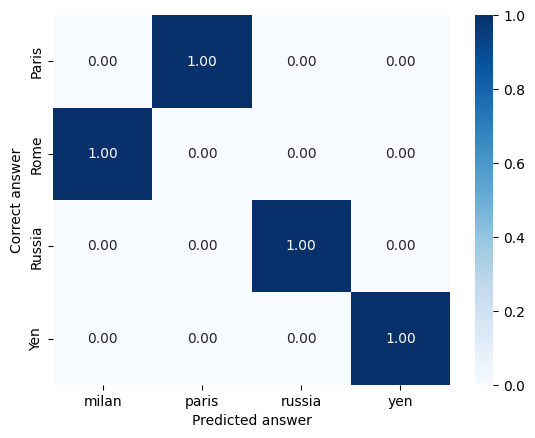

In [19]:
# Load pre-trained BERT model and tokenizer
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

# Define input questions and contexts
input_data = [
    {'question': 'What is the capital of France?', 'context': 'Paris is the capital and most populous city of France.', 'answer': 'Paris'},
    {'question': 'What is the largest country in the world?', 'context': 'Russia is the largest country in the world by land area.', 'answer': 'Russia'},
    {'question': 'What is the capital of Italy?', 'context': 'Milan is a major financial center in Italy.', 'answer': 'Rome'},
    {'question': 'What is the currency of Japan?', 'context': 'Japan has a highly developed economy and uses the yen as its currency.', 'answer': 'Yen'},
]

# Define function to predict answers and compute errors
def predict_answer(model, tokenizer, input_data):
    predicted_answers = []
    correct_answers = []
    for example in input_data:
        question, context, answer = example['question'], example['context'], example['answer']
        input_dict = tokenizer.encode_plus(question, context, return_tensors='pt')
        outputs = model(**input_dict)
        answer_start = torch.argmax(outputs.start_logits)
        answer_end = torch.argmax(outputs.end_logits) + 1
        predicted_answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_dict['input_ids'][0][answer_start:answer_end]))
        predicted_answers.append(predicted_answer)
        correct_answers.append(answer)
    return predicted_answers, correct_answers

# Predict answers and compute errors
predicted_answers, correct_answers = predict_answer(model, tokenizer, input_data)
errors = [1 if predicted_answers[i] != correct_answers[i] else 0 for i in range(len(input_data))]

# Create confusion matrix
data = {'Predicted answer': predicted_answers, 'Correct answer': correct_answers, 'Error': errors}
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['Correct answer'], df['Predicted answer'], values=df['Error'], aggfunc='sum', normalize='index')

# Visualize confusion matrix
sns.heatmap(confusion_matrix, cmap='Blues', annot=True, fmt='.2f')

## NER

### LSTM-CRF with Char Embeddings

In [20]:
# Please see ner_lstm.py for the full code
from ner_lstm import NERLSTM

# Train the model
ner_lstm = NERLSTM()
ner_lstm.train(data="ner_dataset.csv")

2023-04-19 00:45:46.054912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


150/150 [==============================] - 4s 18ms/step
              precision    recall  f1-score   support

         art       0.04      0.25      0.07         8
         eve       0.20      0.42      0.27        19
         geo       0.93      0.86      0.89      4081
         gpe       0.95      0.96      0.95      1502
         nat       0.19      0.50      0.27         6
         org       0.77      0.77      0.77      2064
         per       0.84      0.84      0.84      1837
         tim       0.89      0.90      0.90      1984

   micro avg       0.87      0.86      0.87     11501
   macro avg       0.60      0.69      0.62     11501
weighted avg       0.88      0.86      0.87     11501



(<keras.engine.functional.Functional at 0x1f961be20>,
        loss       acc  val_loss   val_acc
 0  0.505462  0.860781  0.220639  0.930968
 1  0.169105  0.951742  0.133902  0.962635
 2  0.120547  0.965486  0.117720  0.965548
 3  0.103460  0.969605  0.110488  0.967640
 4  0.093903  0.971698  0.106492  0.968718
 5  0.087205  0.973200  0.106942  0.967939
 6  0.082296  0.974457  0.104419  0.969188
 7  0.078456  0.975411  0.104621  0.969518
 8  0.075544  0.976245  0.103489  0.969796
 9  0.072465  0.976965  0.104031  0.970308)

#### transformer based NER, pipeline

In [21]:
# visualize NER

# Load pre-trained BERT model and tokenizer
nlp = pipeline('ner', model='dslim/bert-base-NER', tokenizer='dslim/bert-base-NER', grouped_entities=True)

# Define input sequence
sequence = "Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO, therefore very" \
              "close to the Manhattan Bridge which is visible from the window."

# Get model output
nlp(sequence)

[{'entity_group': 'ORG',
  'score': 0.9935369,
  'word': 'Hugging Face Inc',
  'start': 0,
  'end': 16},
 {'entity_group': 'LOC',
  'score': 0.99946475,
  'word': 'New York City',
  'start': 40,
  'end': 53},
 {'entity_group': 'ORG',
  'score': 0.6780427,
  'word': 'DUMBO',
  'start': 79,
  'end': 84},
 {'entity_group': 'LOC',
  'score': 0.9944114,
  'word': 'Manhattan Bridge',
  'start': 113,
  'end': 129}]

### spaCy NER

#### Loading and cleaning data

In [22]:
# Load data
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

# Create lists of words, POS tags, and named entity tags
words = sorted(set(data["Word"].values))
chars = sorted(set([w_i for w in words for w_i in w]))
tags = sorted(set(data["Tag"].values), reverse=True)

# Create dictionaries mapping words, POS tags, and named entity tags to integers
print(pd.unique(data["Tag"]))
sentences = data.groupby("Sentence #").apply(lambda x: [x["Word"].values.tolist(), x["POS"].values.tolist(), x["Tag"].values.tolist()])
sentences = [[(sentences[i][0][j], sentences[i][1][j], sentences[i][2][j]) for j in range(len(sentences[i][0]))] for i in range(len(sentences))]

['O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']


#### Replacing spaCy's tokenizer due to pre-tokenized data

In [23]:
class WhitespaceTokenizer:
    def __init__(self, vocab):
        # Store the vocab object
        self.vocab = vocab

    def __call__(self, text):
        # Split the text on whitespace characters
        words = text.split(" ")
        spaces = [True] * len(words)
        # Avoid zero-length tokens
        for i, word in enumerate(words):
            if word == "":
                words[i] = " "
                spaces[i] = False
        # Remove the final trailing space
        if words[-1] == " ":
            words = words[0:-1]
            spaces = spaces[0:-1]
        else:
           spaces[-1] = False

        return Doc(self.vocab, words=words, spaces=spaces)

# Load the small English model
nlp = spacy.load("en_core_web_sm")
# Set the tokenizer to the whitespace tokenizer defined above
nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

#### Looking at the differing tags between the two models

In [24]:
print(nlp.pipe_labels['ner'])
print(pd.unique(data["Tag"]))

['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']
['O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']


#### Sorting gold and prediction lists

In [25]:
# Create lists of words, POS tags, and named entity tags
gold = []
pred = []
words = []
all_data_tags = set()
all_spacy_tags = set()

# Create dictionaries mapping words, POS tags, and named entity tags to integers
for i in range(len(sentences)):
    sent = " ".join([sentences[i][j][0] for j in range(len(sentences[i]))])
    doc = nlp(sent)
    predicted = [word.ent_iob_ + ("-" + word.ent_type_ if word.ent_type_ else "") for word in doc]
    true = [sentences[i][j][2] for j in range(len(sentences[i]))]
    wordList = [sentences[i][j][0] for j in range(len(sentences[i]))]
    
    gold += true
    pred += predicted
    words += wordList
    all_data_tags.update(set(true))
    all_spacy_tags.update(set(predicted))

# Create a mapping from the data tags to the spacy tags
spacyToData = {'O':'O', 'B-GPE': 'B-geo', 'I-GPE': 'I-geo', 'B-ORG': 'B-org', 'I-ORG': 'I-org', 'B-TIME': 'B-tim', 'I-TIME': 'I-tim', 'B-WORK_OF_ART': 'B-art', 'I-WORK_OF_ART':'I-art', 'B-LOC':'B-geo', 'I-LOC':'I-geo', 'B-PERSON':'B-per', 'I-PERSON':'I-per', 'B-NORP':'B-gpe', 'I-NORP':'I-gpe', 'B-DATE':'B-tim', 'I-DATE':'I-tim'}
dataCleaning = {'B-nat':'O', 'B-eve':'O', 'I-eve':'O', 'I-nat':'O'}

# Clean the data
pred = [spacyToData.get(i, 'O') for i in pred]
gold = [dataCleaning.get(i) if dataCleaning.get(i) else i for i in gold]

#### Checking weighted F1 (due to sparse labeling)

In [26]:
# Print the F1 score
print(f1_score(gold, pred, average='weighted'))

0.9142151442105265


#### General use spaCy NER

In [27]:
# Load the small English model
nlp = spacy.load("en_core_web_sm")
# Give it a sentence to analyze
doc = nlp("I loved Sundar Pichai's event on Thursday at Google's headquarters in California.")
# Render the dependency parse
displacy.render(doc, style='ent', jupyter=True)

#### End decision: add spaCy NER to pipeline

## Sentiment Analysis

### Improved Naive Bayes Classifier

In [28]:
# Please see sent_analysis_naive_bayes.py for the full code

# Load the IMDB dataset
imdb = load_dataset("imdb")

# Create a small dataset
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(10000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(2000))])

# Create a list of tuples containing the text and label
small_train_dataset = [(str(i), item[0], str(item[1])) for i, item in enumerate(zip(small_train_dataset["text"], small_train_dataset["label"]))]
small_test_dataset = [(str(i), item[0], str(item[1])) for i, item in enumerate(zip(small_test_dataset["text"], small_test_dataset["label"]))]

# Create a TextClassify object
sentiment_analysis = TextClassify()
# Train the model
sentiment_analysis.train(small_train_dataset)

# Evaluate the model
gold = [x[2] for x in small_test_dataset]
predicted = [sentiment_analysis.classify(x[1]) for x in small_test_dataset]
all_score(gold, predicted)

# Classify a sentence
if (sentiment_analysis.classify("I loved the movie. It was awesome!")):
    print("Positive")

Found cached dataset imdb (/Users/arnav/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /Users/arnav/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-9c48ce5d173413c7.arrow
Loading cached shuffled indices for dataset at /Users/arnav/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-c1eaa46e94dfbfd3.arrow


Precision:	 0.6760683760683761
Recall:		 0.791
F1:		 0.7290322580645161
Positive


### Fine-tuned BERT

#### F1 score and other metrics can be found on [the model's page on the HuggingFace hub](https://huggingface.co/joshiarn/my_awesome_model)

In [29]:
# Please see sent_analysis_finetuned.py for the full code

# Model is pulling from pretrained finetuned (by us) BERT model from HuggingFace model hub
sentiment_analysis_finetuned = SentAnalysisFineTunedBERT()
sentiment_analysis_finetuned.train()

# Evaluate the model
print(sentiment_analysis_finetuned.classify(["I loved the movie. It was awesome!"]))
print(sentiment_analysis_finetuned.classify(["I hated the movie. It was terrible!"]))

[{'label': 'POSITIVE', 'score': 0.9940869808197021}]
[{'label': 'NEGATIVE', 'score': 0.9792482852935791}]


### Pretrained BERT

#### Since our pipeline is currently general purpose, pretrained BERT generally performs as well as required. The scores for this model can be found on [its model page](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).

In [30]:
# Please see sent_analysis_bert.py for the full code

# Model is pulling from pretrained BERT model from HuggingFace model hub
sentiment_analysis_bert = SentAnalysisBERT()
# Get the model predictions
print(sentiment_analysis_bert.predict("I loved the movie. It was awesome!"))
print(sentiment_analysis_bert.predict("I hated the movie. It was terrible!"))

# Get the labels and the scores 
print(sentiment_analysis_bert.score("I loved the movie. It was awesome!"))
print(sentiment_analysis_bert.score("I hated the movie. It was terrible!"))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


['1']
['0']
[{'label': 'POSITIVE', 'score': 0.9998801946640015}]
[{'label': 'NEGATIVE', 'score': 0.999599277973175}]


#### Sentiment analysis using transformers, pipeline

In [31]:
nlp_sent = pipeline('sentiment-analysis')

sequence_sent = "I love natural language processing. This is so cool. The voice to text "\
    "analysis and recognition is extremely interesting to all of us. It is very confusing to me. I am learning it though."

# visualize sentiment analysis for each sentence split with "." or "!" or "?"
sequence_sentences = sequence_sent.split(".")
for sentence in sequence_sentences:
    print(sentence)
    print(nlp_sent(sentence))

nlp_sent(sequence_sent)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


I love natural language processing
[{'label': 'POSITIVE', 'score': 0.9998213648796082}]
 This is so cool
[{'label': 'POSITIVE', 'score': 0.9998534917831421}]
 The voice to text analysis and recognition is extremely interesting to all of us
[{'label': 'POSITIVE', 'score': 0.9997827410697937}]
 It is very confusing to me
[{'label': 'NEGATIVE', 'score': 0.9992660880088806}]
 I am learning it though
[{'label': 'POSITIVE', 'score': 0.9976691603660583}]

[{'label': 'POSITIVE', 'score': 0.748120903968811}]


[{'label': 'POSITIVE', 'score': 0.9985349178314209}]

#### End decision: add pretrained BERT to pipeline